In [81]:
from data_proc import increase_contrast, generate_binary_mask
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uuid
import os
import tqdm

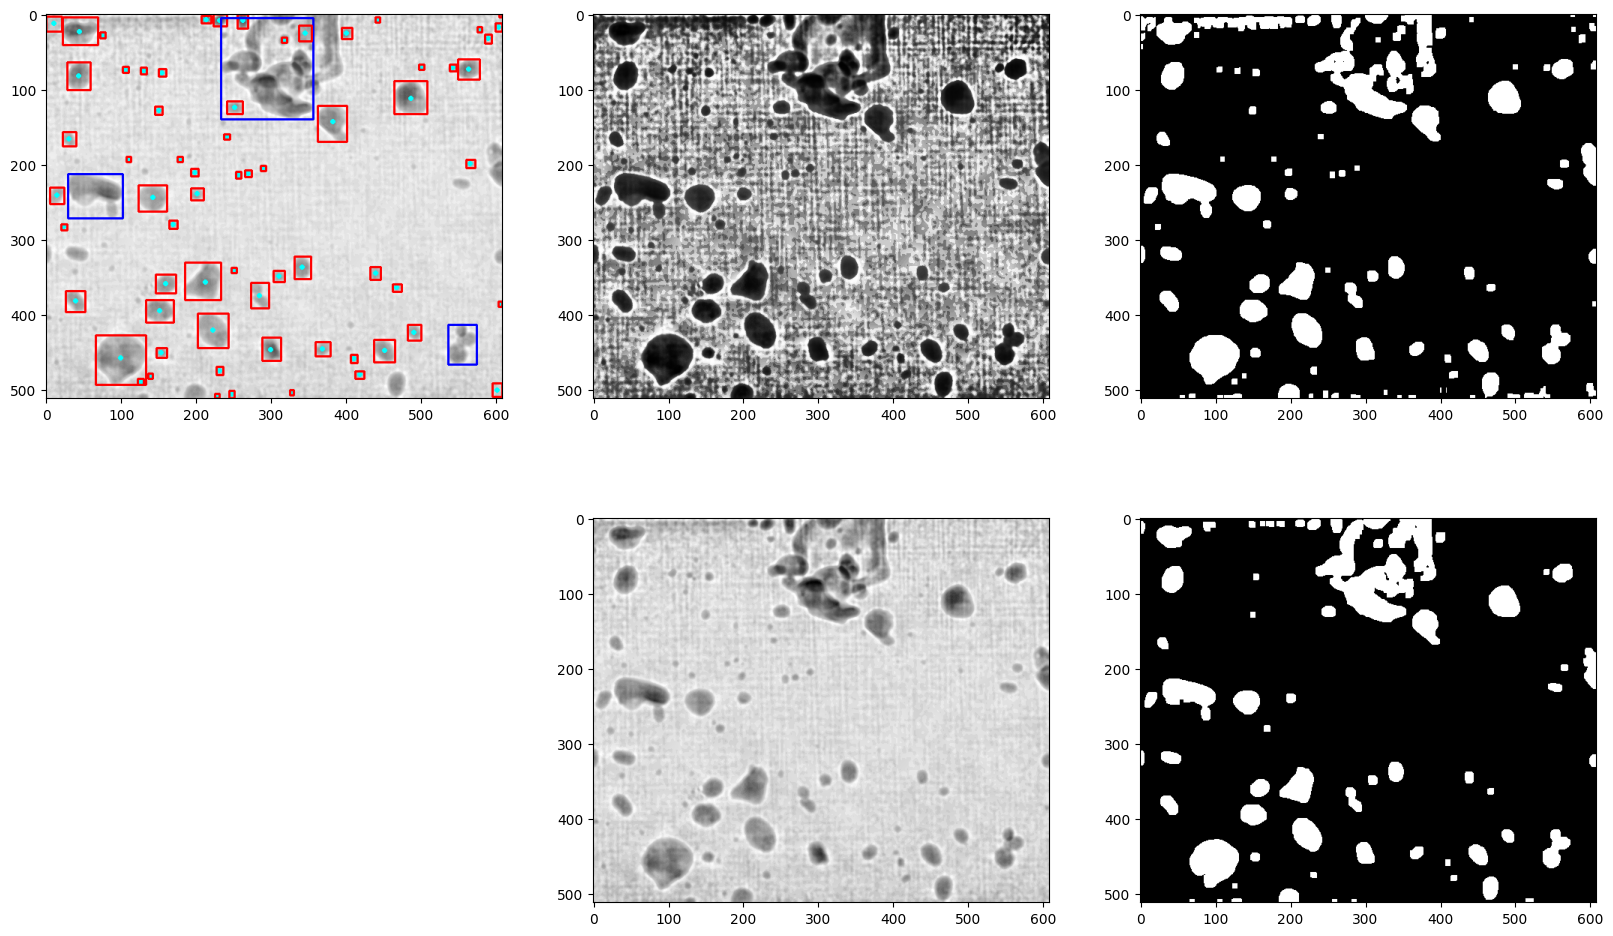

,frame number,in-frame ID,UUID,centroid,area (pixels),diameter (microns)
0,000144,0,c96a3d72-04db-11ef-8d28-ac1f6b09f292,"(231, 8)",236,189.725138
1,000144,1,c96a8926-04db-11ef-8d28-ac1f6b09f292,"(262, 8)",239,197.858598
2,000144,2,c96addb8-04db-11ef-8d28-ac1f6b09f292,"(606, 2)",16,40.519125
3,000144,3,c96b2af2-04db-11ef-8d28-ac1f6b09f292,"(10, 12)",335,250.991183
4,000144,4,c96b71d8-04db-11ef-8d28-ac1f6b09f292,"(213, 7)",121,128.128605
...,...,...,...,...,...,...
61,000144,61,c97b8ef6-04db-11ef-8d28-ac1f6b09f292,"(126, 490)",63,94.542091
62,000144,62,c97bd0e6-04db-11ef-8d28-ac1f6b09f292,"(601, 501)",175,185.429379
63,000144,63,c97c139e-04db-11ef-8d28-ac1f6b09f292,"(327, 504)",35,68.867937
64,000144,64,c97c55d4-04db-11ef-8d28-ac1f6b09f292,"(247, 506)",70,103.300960


In [85]:
def droplets_to_df(image_path, aspect_ratio_range=(0.7, 1.3), min_obj_box_ratio = 0.6, microns_per_px = 9.55, show_fig = False):
    df = pd.DataFrame(columns=['frame number', 'in-frame ID', 'UUID', 'centroid', 'area (pixels)', 'diameter (microns)'])
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # image = cv2.fastNlMeansDenoising(image, h= 3, templateWindowSize= 7, searchWindowSize=21)

    imageb = cv2.GaussianBlur(image, (9,9), 0)
    contrast_image = increase_contrast(imageb, grid_size=(29,29))
    contrast_image2 = increase_contrast(contrast_image, grid_size=(5,5))
    _, c2ibw = cv2.threshold(contrast_image2, 86,255,cv2.THRESH_BINARY_INV)
    c2ibw = cv2.erode(c2ibw, np.ones((1,7)))
    c2ibw = cv2.dilate(c2ibw, np.ones((1,7)))
    c2ibw = cv2.erode(c2ibw, np.ones((7,1)))
    c2ibw = cv2.dilate(c2ibw, np.ones((7,1)))
    # c2ibw = cv2.dilate(c2ibw, np.ones((7,7)))

    _,c1ibw = cv2.threshold(contrast_image, 200,255,cv2.THRESH_BINARY_INV)
    c1ibw = cv2.erode(c1ibw, np.ones((1,7)))
    c1ibw = cv2.erode(c1ibw, np.ones((7,1)))
    c1ibw = cv2.dilate(c1ibw, np.ones((7,7)))
    # cv2.imshow('normal binary', c2ibw)
    
    # cv2.imshow('og image', image)
    # cv2.imshow('contrast', contrast_image)

    num_ccs, ccs, stats, centroids = cv2.connectedComponentsWithStats(c2ibw)
    
    # For annotation and visualization purposes, we colorize the first-pass contrasted image
    image_c = cv2.cvtColor(contrast_image, cv2.COLOR_GRAY2BGR)
    frame_id = 0
    for i in range(1, num_ccs):
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        aspect_ratio = width / height

        # Check if aspect ratio falls within the specified range
        if aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]:
            x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], width, height
            cc_area = stats[i, cv2.CC_STAT_AREA]
            bb_area = w * h

            # Check if area of connected component is at least a certain percentage of its bounding box area
            if cc_area/bb_area >= min_obj_box_ratio:
                _, radius = cv2.minEnclosingCircle(np.array(np.where(ccs == i)).transpose())
                cx, cy = round(centroids[i][0]), round(centroids[i][1])
                
                if show_fig:
                    cv2.circle(image_c, (cx,cy), 2, (0,255,255), 2)
                    cv2.rectangle(image_c, (x, y), (x + w, y + h), (255, 0, 0), 2)
                
                data = {'frame number': image_path[-10:-4], 
                        'in-frame ID': frame_id, 
                        'UUID': uuid.uuid1(), 
                        'centroid': (cx, cy), 
                        'area (pixels)': cc_area, 
                        'diameter (microns)': radius*2*microns_per_px}
                df.loc[len(df.index)] = data
                frame_id += 1
            elif show_fig:
                cv2.rectangle(image_c, (x, y), (x + w, y + h), (0, 0, 255), 2)

           
    
    if show_fig:
        plt.figure(figsize=(20,12))
        plt.subplot(231)
        plt.imshow(image_c, cmap='gray')
        plt.subplot(232)
        plt.imshow(contrast_image2, cmap='gray')
        plt.subplot(233)
        plt.imshow(c2ibw, cmap='gray')
        plt.subplot(235)
        plt.imshow(contrast_image, cmap='gray')
        plt.subplot(236)
        plt.imshow(c1ibw, cmap='gray')
        plt.show()
    return df

# df = pd.DataFrame(columns=['frame number', 'in-frame ID', 'UUID', 'centroid', 'area (pixels)', 'diameter (microns)'])
# for file in tqdm.tqdm(os.listdir('Data')):
#     df = pd.concat([df, droplets_to_df(os.path.join('Data',file))])

# df.to_csv('HEINDEL_CLASSIC.csv')
droplets_to_df('Data/000144.png', show_fig=True)